## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [17]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

разделил данные train на train и validation

In [19]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [20]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [21]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [29]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [22]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [23]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [24]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [25]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [26]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [27]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [30]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
embedding_dim = 16

In [33]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [35]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
epochs = 14
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/14
200/200 [==============================] - 6s 24ms/step - loss: 1.3789 - accuracy: 0.3381 - val_loss: 1.3681 - val_accuracy: 0.4756
Epoch 2/14
200/200 [==============================] - 1s 5ms/step - loss: 1.3514 - accuracy: 0.4555 - val_loss: 1.3314 - val_accuracy: 0.5331
Epoch 3/14
200/200 [==============================] - 1s 5ms/step - loss: 1.3022 - accuracy: 0.5314 - val_loss: 1.2722 - val_accuracy: 0.5744
Epoch 4/14
200/200 [==============================] - 1s 5ms/step - loss: 1.2341 - accuracy: 0.5780 - val_loss: 1.1978 - val_accuracy: 0.6281
Epoch 5/14
200/200 [==============================] - 1s 5ms/step - loss: 1.1538 - accuracy: 0.6305 - val_loss: 1.1187 - val_accuracy: 0.6575
Epoch 6/14
200/200 [==============================] - 1s 5ms/step - loss: 1.0769 - accuracy: 0.6672 - val_loss: 1.0456 - val_accuracy: 0.6894
Epoch 7/14
200/200 [==============================] - 1s 4ms/step - loss: 1.0047 - accuracy: 0.7077 - val_loss: 0.9800 - val_accuracy: 0.7075
Epoch

In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 12s 45ms/step - loss: 0.7444 - accuracy: 0.7541
Loss:  0.7444467544555664
Accuracy:  0.7541249990463257


Ужасная точноть (

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

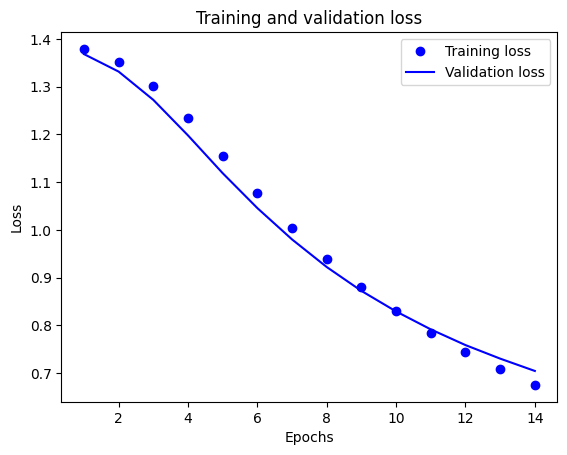

In [41]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

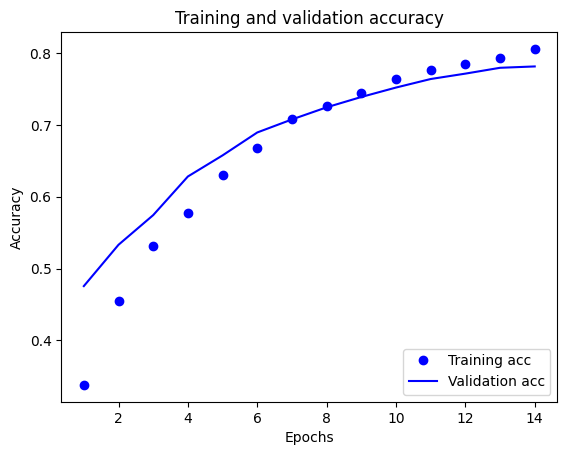

In [42]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [43]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

D:\Programms\Python 3\lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 11s 41ms/step - loss: 0.7444 - accuracy: 0.7541
0.7541249990463257
